# KNN: K-Nearest Neighbors

En este notebooks, vamos a implementar el algoritmo de clasificación de K vecinos más cercanos usando la libreria Scikit-learn. Además, vamos a evaluar los resultados obtenidos para distintos valores del hiperparámetro k (número de vecinos).

## 1. Clasificación en el dataset IRIS

Para comenzar, vamos a trabajar con un dataset que ya conocemos, el de IRIS.

### 1.1 Cargar el dataset

Primero cargamos las librerias y el dataset que vamos a usar (el cual en este caso lo traemos desde la libreria Seaborn). Separamos el dataset entre features, `X`, y labels `y`.

In [ ]:
import pandas as pd
import seaborn as sns

#iris = pd.read_csv("../00_datasets/iris_dataset.csv")
iris = sns.load_dataset('iris')

In [ ]:
iris.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


In [ ]:
X = iris.drop("species", axis=1)
y = iris.species
X.head(10)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


Luego, vamos a separar el dataset en conjuntos de entrenamiento *X_train*, *y_train* y de testeo *X_test*, *y_test* usando la función **train_test_split** de scikit-learn. Esto lo hacemos para separar parte de los datos *X_test*, *y_test* con los cuales NO vamos a entrenar el dataset, y vamos a usarlos únicamente para evaluar el resultado de nuestro algoritmo.

Separamos el Dataset, tomando en las variables *X_train*, *y_train* un 90% para entrenamiento y en las variables *X_test*, *y_test* un 10% para evaluación:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(135, 4)
(15, 4)
(135,)
(15,)


### 1.2 Preprocesamiento de Datos

Antes de implementar un algoritmo del tipo de KNN (algoritmo que trabaja por distancia), es muy importante estandarizar los datos normalizar los datos. Veamos algunos valores estadisticos de los distintos Features de nuestro Dataset:

In [ ]:
print('Maximos: \n',X_train.max(),'\n \n Mínimas: \n',X_train.min(),'\n')
print('Means: \n',X_train.mean(),'\n \n Std: \n',X_train.std())

Maximos: 
 sepal_length    7.9
sepal_width     4.4
petal_length    6.9
petal_width     2.5
dtype: float64 
 
 Mínimas: 
 sepal_length    4.3
sepal_width     2.0
petal_length    1.0
petal_width     0.1
dtype: float64 

Means: 
 sepal_length    5.829630
sepal_width     3.057037
petal_length    3.751111
petal_width     1.205185
dtype: float64 
 
 Std: 
 sepal_length    0.825171
sepal_width     0.444626
petal_length    1.756517
petal_width     0.766687
dtype: float64


Como se puede observar, los features poseen diferentes escalas (la media de la variables *sepal_length* es 5 veces la media de la variable *petal_width*). Pasemos entonces a estandarizar estos datos.

Apliquemos la función **StandardScaler** (que deben importar desde **sklearn.preprocessing**):

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Volvamos a analizar los mismos estadísticos luego de la transformación:

In [ ]:
print('Maximos: \n',pd.DataFrame(X_train).max(),'\n \n Mínimas: \n',pd.DataFrame(X_train).min(),'\n')
print('Means: \n',pd.DataFrame(X_train).mean(),'\n \n Std: \n',pd.DataFrame(X_train).std())

Maximos: 
 0    2.518366
1    3.031679
2    1.799365
3    1.695134
dtype: float64 
 
 Mínimas: 
 0   -1.860617
1   -2.386214
2   -1.572064
3   -1.446877
dtype: float64 

Means: 
 0   -3.421132e-16
1    5.592234e-16
2    1.513193e-16
3    8.552829e-17
dtype: float64 
 
 Std: 
 0    1.003724
1    1.003724
2    1.003724
3    1.003724
dtype: float64


**Para pensar**:
* ¿Por qué será que es tan importante estandarizar los datos en el caso de usar un algoritmo de KNN?

Como se calcula la similitud con respecto a la distancia, debemos tener en mente que las distancias entre variables deben ser comparables. Si usamos un rango de medida en una variable y otro muy distinto en otra, las distancias no están normalizadas/estandarizadas y estaremos comparando peras con manzanas. Para realizar un análisis con KNN tenemos siempre que estandartizar los datos, re-escalar todas las variables para que las distancias sean equiparables. Este proceso se suele llamar: estandarización de los datos. Otro importante asunto es que hay que eliminar los NA de los datos, pues afectan a los cálculos de distancia.
Por último, como se indicó antes, este modelo es válido solo para casos con pocas dimensiones en los datos, pocos grados de libertad. Cuando se incrementa la dimensión espacial de los datos, la complejidad y el cálculo se hacen inviables.

### 1.3 Implementar el clasificador KNN
**scikit-learn** implementa dos clasificadores diferentes de vecinos más cercanos:
* **KNeighborsClassifier** implementa el aprendizaje basado en los k vecinos más cercanos, donde k es un valor entero especificado por el usuario.
* **RadiusNeighborsClassifier** implementa el aprendizaje en base al número de vecinos dentro de un radio fijo r de cada punto de entrenamiento, donde r es un valor de punto flotante especificado por el usuario.

Vamos a importar la clase del modelo KNN desde scikit-learn usando la siguiente linea: `from sklearn.neighbors import KNeighborsClassifier`.

Cuando creamos un objeto de esta clase, podemos definir el valor de algunos atributos del modelo. Estos atributos son los **hiperparámetros** que queremos utilizar. En el caso de este modelo, estos atributos van a ser la métrica de la distancia (que por default es la euclideana) y, el más importante, el número de vecinos `k`. Vamos a cargar el modelo utilizando `k=2` vecinos.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbors = 2
clf = KNeighborsClassifier(n_neighbors =n_neighbors )

In [ ]:
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 2,
 'p': 2,
 'weights': 'uniform'}

Ahora entrenaremos el modelo con el set de entrenamiento y predecir las etiquetas tanto sobre el set de entrenamiento (train) como en el set de test (prueba).

In [ ]:
clf.fit(X_train,y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

Para evaluar el porcentaje de aciertos en la predicción de las etiquetas, vamos a utilizar la función accuracy_score que importamos desde sklearn.metrics

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 0.9777777777777777
Porcentaje de aciertos sobre el set de evaluación: 0.9333333333333333


**Pregunta**:

1. ¿Será el parámetro de `k=2` el mejor para elegir en nuestro modelo?¿Cómo podríamos saberlo?

### 1.4 Encontrar el mejor hiperparámetro
Para esto, debemos evaluar el accuracy del modelo en el set de evaluación para distintos valores del parámetro `k`. Vamos entonces a repetir el esquema de: **definir, entrenar y predecir** en un loop `for` que recorre una lista con distintos valores de `k`.

In [ ]:
# Definimos las listas vacias para los valores de accuracy deseados
lista_accuracy_train = []
lista_accuracy_test = []

# Definimos la lista de valores de k que vamos a explorar
k_vecinos = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40]

# Generamos en loop sobre los distintos valores de k
for k in k_vecinos:

    # Vamos a repetir el siguiente bloque de código

    # Definir el modelo con el valor de vecinos deseado
    clf = KNeighborsClassifier(n_neighbors=k)

    # Entrenar el modelo
    clf.fit(X_train,y_train)

    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)

    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Agregar la información a las listas
    lista_accuracy_train.append(train_acc)
    lista_accuracy_test.append(test_acc)

Realizaremos un gráfico que muestre la curvas de accuracy en el set de entrenamiento (`lista_accuracy_train`) y accuracy en el set de entrenamiento (`lista_accuracy_test`) en función del numero de vecinos (`k_vecinos`).

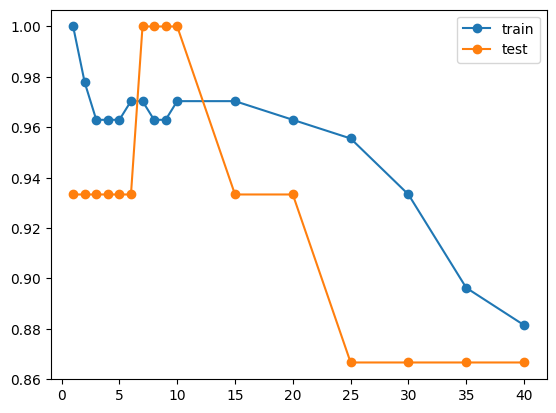

In [ ]:
import matplotlib.pyplot as plt

plt.plot(k_vecinos,lista_accuracy_train,'o-',label='train' )
plt.plot(k_vecinos,lista_accuracy_test,'o-',label='test')
plt.legend()

**Para pensar**:
1. Para el caso de `k = 1`, donde la performance en el set de entrenamiento es mucho mayor a la performance en el set de test. ¿En que tipo de régimen diría que se encuentra el modelo? ¿Por qué?
Con k = 1 en el conjunto de entrenamiento la predicción es 100% es lógico porque cada muestra solo se etiquetará con su propia etiqueta.

2. ¿Qué valor de `k` eligiría? ¿Por qué?
Un valor de K que minimice la diferencia entre la exactitud entre el set de entrenamiento y prueba.  

El siguiente bloque de codigo produce gráficos de la frontera de decisión para un clasificador KNN entrenado en el IRIS dataset utilizando distintos valores del hiperparámetro k. Con el fin de poder graficar los resultados, utilizamos sólo dos Features.

No hace falta que modifique el código, sólo analice los gráficos producidos y vuelva a pensar las tres preguntas anteriores en términos de Underfitting y Overfitting.

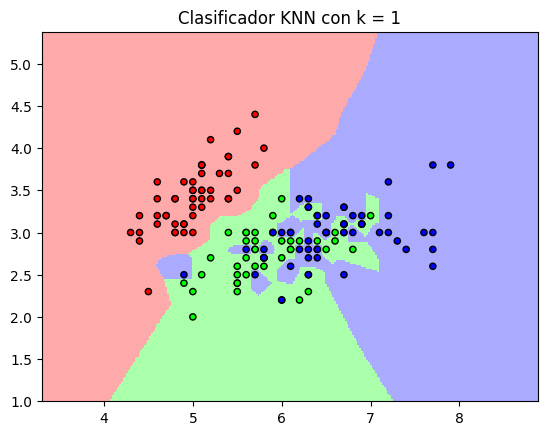

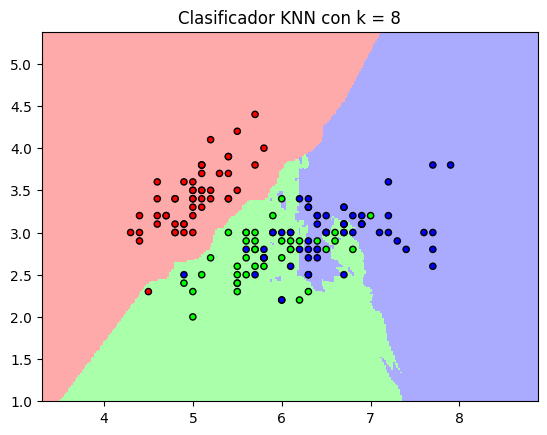

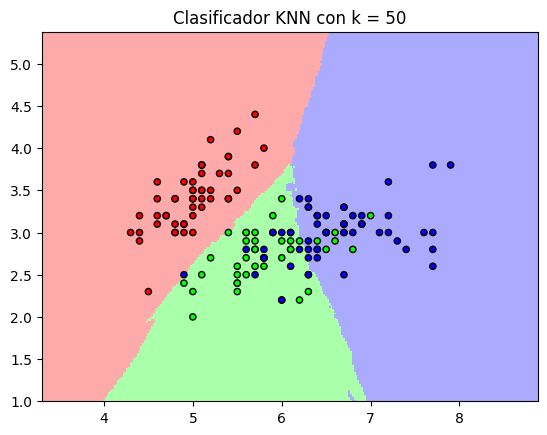

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for k in [1,8,50]:

    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Clasificador KNN con k = %i"% (k))

### 1.5 KNN con distintos metodología para seleccionar los vecinos mas cercanos (weights).
La clasificación básica de los vecinos más cercanos utiliza pesos uniformes: es decir, el valor asignado a un punto de consulta se calcula a partir de una mayoría simple de votos de los vecinos más cercanos. Bajo algunas circunstancias, es mejor pesar a los vecinos de tal manera que los vecinos más cercanos contribuyan más al ajuste. Esto se puede lograr a través de los pesos. El valor por defecto, **weights ="uniforme"**, asigna pesos uniformes a cada vecino. **weights ="distancia"** asigna pesos proporcionales a la distancia inversa del punto de consulta. Alternativamente, se puede suministrar una función de la distancia definida por el usuario que se utiliza para calcular los pesos.

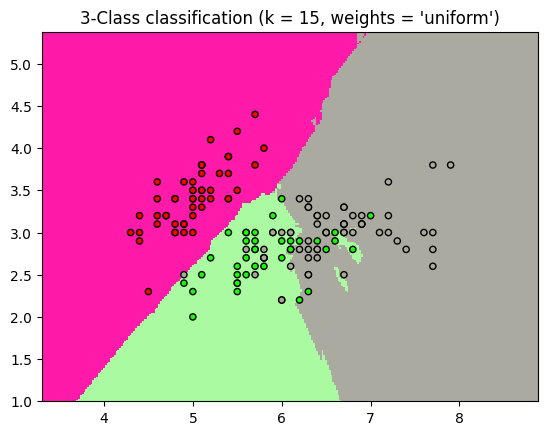

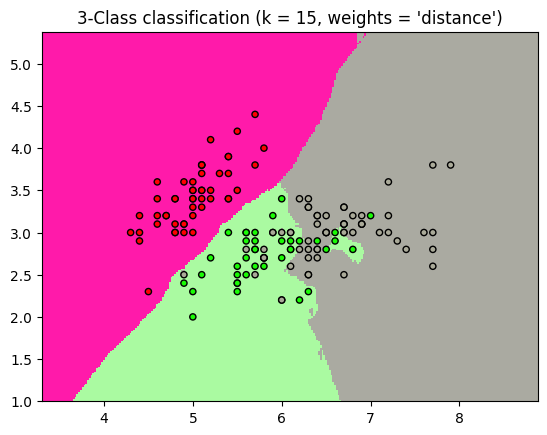

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

# Importar algunos datos para jugar
iris = datasets.load_iris()

# en X solo tomamons coordenadas 2D
# y tiene los conjuntos de 0, 1 y 2
X = iris.data[:, :2]
y = iris.target

# tamaño del paso en la malla
h = .02

# Create color maps
cmap_light = ListedColormap(['#FF1AAA', '#AAFAA1', '#AAAAA1'])
cmap_bold = ListedColormap(['#FF0000', '#19FA05', '#AAAA99'])

for weights in ['uniform', 'distance']:
  # creamos una instancia de Clasificador de Vecinos y encajamos los datos.
  clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
  clf.fit(X, y)

  #Plotea el límite de decisión. Para ello, asignaremos un color a cada uno de ellos.
  # puntos de la malla [x_min, x_max]x[y_min, y_max].
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
  np.arange(y_min, y_max, h))
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

  # Pon el resultado con colores
  Z = Z.reshape(xx.shape)
  plt.figure()
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

  # plotea tambien los puntos de entrenamiento
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,edgecolor='k', s=20)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  plt.title("3-Class classification (k = %i, weights = '%s')"
            % (n_neighbors, weights))

plt.show()